In [1]:
import sys
import os
import numpy as np
import cv2
from imageio import imread
import matplotlib.pyplot as plt
import torch

sys.path.append('../../')
from src.utils.common import set_gpu
from src.models.predictor.keypoint import Predictor
from src.visualize.keypoint_visualization import draw_points, draw_skeleton, draw_points_and_skeleton, joints_dict

## Preparation for prediction 

### Load Configuration

In [2]:
from hydra.experimental import initialize, compose
from omegaconf import OmegaConf

with initialize(config_path="../../configs"):
    cfg = compose(overrides=["+data=keypoint",
                             "+test=keypoint",
                             "+system=system",])
    model_cfg = compose(overrides=["+model=keypoint/hrnet",
                             "+loss=keypoint"])
    print(cfg)
    print(model_cfg)

{'DATA': {'DATA_ID': 'demo_keypoint', 'CSV_PATH': 'demo_trainval.pkl', 'N_FOLD': 1, 'FORMAT': 'mpii', 'BASE_SIZE': 256.0, 'BASE_SIGMA': 2.0, 'SCALE_AWARE_SIGMA': False, 'SCALE_TYPE': 'short', 'SIGMA': 2, 'WITH_CENTER': False, 'INT_SIGMA': False, 'MAX_NUM_PEOPLE': 30}, 'TEST': {'BATCH_SIZE': 1, 'DETECTION_THRESHOLD': 0.1, 'PCK_FACTOR': 0.5, 'PCK_THRESHOLD': 100, 'OKS_FACTOR': 0.1, 'OKS_THRESHOLD': 0.5}, 'SYSTEM': {'DEVICE': 'GPU', 'GPUS': [1], 'SEED': False, 'NUM_WORKERS': 4, 'CUDNN': {'ENABLED': True, 'BENCHMARK': True, 'DETERMINISTIC': False}}}
{'MODEL': {'MODEL_NAME': 'kpt_higher_hrnet', 'BACKBONE': 'hrnet', 'WEIGHT_PATH': 'pretrained/best_loss.pth', 'WO_HEAD': False, 'INPUT_SIZE': 512, 'OUTPUT_SIZE': [128, 256], 'NUM_JOINTS': 16, 'TAG_PER_JOINT': True, 'EXTRA': {'DECONV': {'CAT_OUTPUT': [True], 'KERNEL_SIZE': [4], 'NUM_BASIC_BLOCKS': 4, 'NUM_CHANNELS': [32], 'NUM_DECONVS': 1}, 'FINAL_CONV_KERNEL': 1, 'PRETRAINED_LAYERS': ['*'], 'STAGE2': {'BLOCK': 'BASIC', 'FUSE_METHOD': 'SUM', 'NUM

### select device

In [3]:
gpu_id = [int(gid) for gid in cfg.SYSTEM.GPUS]
set_gpu(gpu_id)

### Load Predictor

In [4]:
joints_set = cfg.DATA.FORMAT
jdict = joints_dict()[joints_set]

model_cfg.MODEL.WO_HEAD = False
model_cfg.MODEL.WEIGHT_PATH = 'pretrained/best_loss.pth'

model = Predictor(
    cfg,
    model_cfg,
    return_bounding_boxes=False
)

## Prediction

### Load image

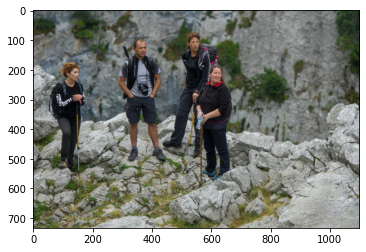

In [5]:
img = imread('../../data/demo_keypoint/raw/images/2017-09-23-14-22-45-1100x733.jpg')
plt.imshow(img)

### Prediction

In [6]:
pts = model.predict_image(img)

### Visualization

In [7]:
person_ids = np.arange(len(pts), dtype=np.int32)

for i, (pt, pid) in enumerate(zip(pts, person_ids)):
    img = draw_points_and_skeleton(img, pt, jdict['skeleton'], person_index=pid,
                                   points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                   points_palette_samples=10, confidence_threshold=cfg.TEST.DETECTION_THRESHOLD)

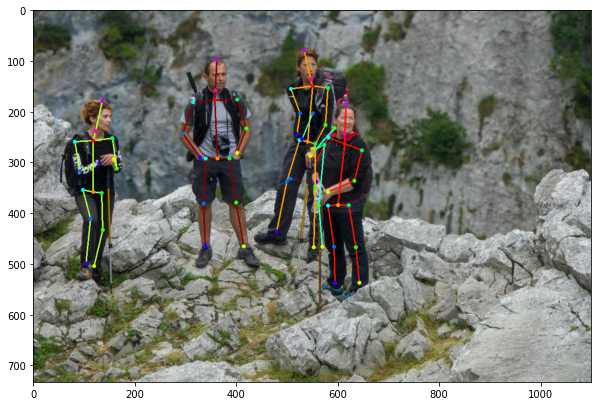

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(img)